In [1]:
#Standard
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

#AIF360 Dataset Classes 
from aif360.datasets import StandardDataset
from aif360.datasets import BinaryLabelDataset

#AIF360 Metrics Classes  
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric

from aif360.metrics import ClassificationMetric

#AIF360 Algorithms 
from aif360.algorithms.preprocessing import Reweighing
from aif360.algorithms.inprocessing import AdversarialDebiasing
from aif360.algorithms.postprocessing import CalibratedEqOddsPostprocessing, EqOddsPostprocessing
# AI360 Explainers
from aif360.explainers import MetricTextExplainer

#Sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV,train_test_split

#Tensorflow -- install version before 2.0
import tensorflow as tf 

#For Markdown
from IPython.display import Markdown, display

#Helper Functions
from src.classifier_functions import *
from src.dataset_functions import *

//anaconda3/lib/python3.7/site-packages/dask/dataframe/utils.py:15: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [224]:
salary_list = [60000, 100000, 150000, 200000, 250000, 300000, 350000]

In [225]:
datasets = create_multiple_datasets(create_binary_dataset_salary, salary_list)

In [226]:
means, impact = get_dataset_metrics_list(datasets)


In [227]:
means

[-0.002797514915318544,
 -0.14185487472152958,
 -0.15509419201537045,
 -0.12145545439959105,
 -0.06845718960460986,
 -0.04120975631200614,
 -0.015883927270456254]

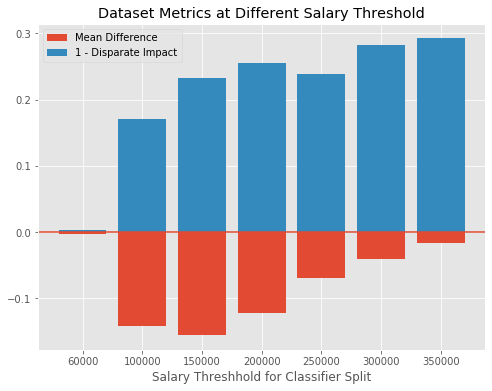

In [228]:
fig, ax = plt.subplots(figsize = (8,6))
x_axis = range(len(salary_list))

ax.bar(x_axis, means, label='Mean Difference' )
ax.bar(x_axis, impact, label='1 - Disparate Impact')
ax.axhline(0)
ax.set_xticks(x_axis)
ax.set_xticklabels(salary_list)
ax.set_title('Dataset Metrics at Different Salary Threshold')
ax.set_xlabel('Salary Threshhold for Classifier Split')
ax.legend()
plt.savefig('images/model_metrics')

In [229]:
x_axis

range(0, 7)

In [230]:
salary_list

[60000, 100000, 150000, 200000, 250000, 300000, 350000]

In [231]:
def create_split_lists(dataset_list):
    #Create Train, Validation, Test Sets
    data_train_list =[]
    data_val_list = []
    data_test_list =[]
    for dataset in dataset_list:
        data_train, data_vt = dataset.split([0.7], shuffle=True)
        data_val, data_test = data_vt.split([0.5], shuffle=True)

        data_train_list.append(data_train)
        data_val_list.append(data_val) 
        data_test_list.append(data_test) 
    return data_train_list, data_val_list, data_test_list 
    


In [232]:
train_list, val_list, test_list = create_split_lists(datasets)

In [236]:
def get_predictions(estimator, train_list, test_list):
    pred_list = []
    for train_, test_ in zip(train_list, test_list):
        X_train = train_.features
        y_train = train_.labels.ravel()
        X_test = test_.features  
        model = estimator
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        preds = test_.copy()
        preds.labels = y_pred.ravel()
        pred_list.append(preds)
    return pred_list

    

In [237]:
pred_list = get_predictions(RandomForestClassifier(n_estimators=500, max_depth=5, ), 
                train_list, val_list)

In [162]:
val_list[0].features

array([[1., 0., 4., ..., 0., 0., 1.],
       [1., 1., 3., ..., 1., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 1.],
       [1., 1., 1., ..., 1., 0., 0.],
       [0., 0., 2., ..., 0., 0., 1.]])

In [156]:
#get_classifier_metrics()

aif360.datasets.binary_label_dataset.BinaryLabelDataset

In [184]:
def show_classifier_metrics(test_list, prediction_list):
    privileged_groups= [{'sex':1}]
    unprivileged_groups= [{'sex': 0}]
    
    
    counter = 1 
    for test_, pred_ in zip(test_list, prediction_list):
        
        display(Markdown("#### Model {}  dataset metrics".format(counter)))
        

        model_metric = ClassificationMetric(test_, pred_, 
                            unprivileged_groups=unprivileged_groups, 
                            privileged_groups=privileged_groups)

        ex_model_metric= MetricTextExplainer(model_metric)
        print(ex_model_metric.average_odds_difference())

        print('Difference in Recall between Unprivileged and Privileged: {:.3f}'
          .format(model_metric.equal_opportunity_difference()))

        print('Difference in Precision between Unprivileged and Privileged: {:.3f}.'
            .format(model_metric.precision(privileged=False)- model_metric.precision(privileged=True)))
        counter +=1

In [238]:
show_classifier_metrics(val_list, pred_list)



#### Model 1  dataset metrics

Average odds difference (average of TPR difference and FPR difference, 0 = equality of odds): 0.0
Difference in Recall between Unprivileged and Privileged: 0.000
Difference in Precision between Unprivileged and Privileged: -0.004.


#### Model 2  dataset metrics

Average odds difference (average of TPR difference and FPR difference, 0 = equality of odds): -0.14063700413138747
Difference in Recall between Unprivileged and Privileged: -0.069
Difference in Precision between Unprivileged and Privileged: -0.035.


#### Model 3  dataset metrics

Average odds difference (average of TPR difference and FPR difference, 0 = equality of odds): -0.17854914464416427
Difference in Recall between Unprivileged and Privileged: 0.001
Difference in Precision between Unprivileged and Privileged: 0.006.


#### Model 4  dataset metrics

Average odds difference (average of TPR difference and FPR difference, 0 = equality of odds): -0.07749304358000009
Difference in Recall between Unprivileged and Privileged: -0.028
Difference in Precision between Unprivileged and Privileged: 0.079.


#### Model 5  dataset metrics

Average odds difference (average of TPR difference and FPR difference, 0 = equality of odds): -0.0021880333227537185
Difference in Recall between Unprivileged and Privileged: -0.003
Difference in Precision between Unprivileged and Privileged: -0.167.


#### Model 6  dataset metrics

Average odds difference (average of TPR difference and FPR difference, 0 = equality of odds): 0.0
Difference in Recall between Unprivileged and Privileged: 0.000
Difference in Precision between Unprivileged and Privileged: 0.000.


#### Model 7  dataset metrics

Average odds difference (average of TPR difference and FPR difference, 0 = equality of odds): -0.009007936507936508
Difference in Recall between Unprivileged and Privileged: -0.020
Difference in Precision between Unprivileged and Privileged: -1.000.


In [239]:
def get_classifier_metrics(test_list, prediction_list):
    privileged_groups= [{'sex':1}]
    unprivileged_groups= [{'sex': 0}]
    acc_list = []
    bal_acc_list = []
    avg_odds_list=[]
    recall_diff_list = []
    precision_diff_list = []
    for test_, pred_ in zip(test_list, prediction_list):
        model_metric = ClassificationMetric(test_, pred_, 
                            unprivileged_groups=unprivileged_groups, 
                            privileged_groups=privileged_groups)
        
        acc_list.append(model_metric.accuracy().round(3))
        bal_acc_list.append(((model_metric.true_positive_rate()+ model_metric.true_negative_rate(privileged=True))/2).round(3))
        avg_odds_list.append(model_metric.average_odds_difference().round(3))
        recall_diff_list.append(model_metric.equal_opportunity_difference().round(3))
        precision_diff_list.append((model_metric.precision(privileged=False)- model_metric.precision(privileged=True)).round(3))  
    return acc_list, bal_acc_list, avg_odds_list, recall_diff_list, precision_diff_list

In [240]:
classifier_stats = get_classifier_metrics(val_list, pred_list)

In [241]:
classifier_stats

([0.995, 0.889, 0.8, 0.654, 0.737, 0.865, 0.951],
 [0.5, 0.739, 0.647, 0.599, 0.503, 0.5, 0.507],
 [0.0, -0.141, -0.179, -0.077, -0.002, 0.0, -0.009],
 [0.0, -0.069, 0.001, -0.028, -0.003, 0.0, -0.02],
 [-0.004, -0.035, 0.006, 0.079, -0.167, 0.0, -1.0])

In [114]:
def rescue_code(function):
    import inspect
    get_ipython().set_next_input("".join(inspect.getsourcelines(function)[0]))
rescue_code(get_predictions)

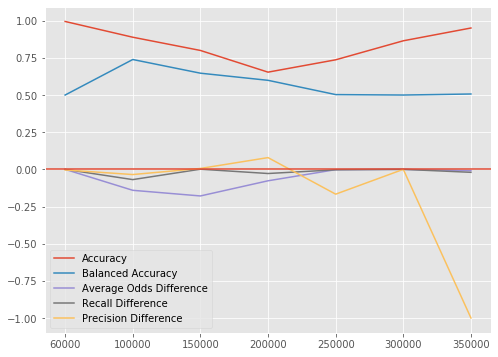

In [246]:
fig, ax = plt.subplots(figsize = (8,6))
x_axis = range(len(classifier_stats[0]))

ax.plot(x_axis, classifier_stats[0], label='Accuracy' )
ax.plot(x_axis, classifier_stats[1], label='Balanced Accuracy' )
ax.plot(x_axis, classifier_stats[2], label='Average Odds Difference' )
ax.plot(x_axis, classifier_stats[3], label='Recall Difference' )
ax.plot(x_axis, classifier_stats[4], label='Precision Difference' )

ax.axhline(0)
ax.set_xticks(x_axis)
ax.set_xticklabels(salary_list)
# ax.set_title('Dataset Metrics at Different Salary Threshold')
# ax.set_xlabel('Salary Threshhold for Classifier Split')
ax.legend()
#plt.savefig('images/model_metrics')